In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append("../../..")
from utils import utils, postprocessing_utils as post
from utils.plotting_utils import plots

In [3]:
def group_transfer(task, short_model_name, metric, grouped_train=True, grouped_test=True):
    params = {
        "results_dir": "../../../results/",
        "experiment": "acl-score-limit",
        "short_model_name": short_model_name,
        "task": task,
        "metric": metric
    }

    M = post.Metrics(**params)
    df = M.transfer_loss(grouped_train=grouped_train, grouped_test=grouped_test)
    df_same = df[df["Train-Group"] == df["Test-Group"]]
    df_others = df[df["Train-Group"] != df["Test-Group"]]
    df_same.loc[:, "Test-Group"] = "Intra-Group"
    if grouped_train:
        df_others = df_others.groupby("Train-Group", sort=False, as_index=False).mean()
    df_others["Test-Group"] = "Inter-Group"

    final = pd.concat([df_same, df_others]).reset_index(drop=True)
    final.loc[:, ["Within-Score", "Cross-Score", "Transfer-Loss"]] *= 100
    if task == "pos":
        final["Task"] = "Part-of-Speech"
    elif task == "sentiment":
        final["Task"] = "Sentiment Analysis"
    if short_model_name == "mbert":
        final["Model"] = "mBERT"
    elif short_model_name == "xlm-roberta":
        final["Model"] = "XLM-R"
    return final

In [4]:
df = pd.DataFrame()

for task, metric in [("pos", "Accuracy"), ("sentiment", "Macro_F1")]:
    for short_model_name in ["mbert", "xlm-roberta"]:
        temp = group_transfer(task, short_model_name, metric)
        temp = temp.groupby(["Test-Group", "Task", "Model"], sort=False, as_index=False).mean()
        df = pd.concat([df, temp], ignore_index=True)

e:\anaconda\envs\tfm_ccil\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [5]:
df

,Test-Group,Task,Model,Within-Score,Cross-Score,Transfer-Loss
0,Intra-Group,Part-of-Speech,mBERT,82.226004,53.453577,28.772427
1,Inter-Group,Part-of-Speech,mBERT,82.226004,47.360502,34.865502
2,Intra-Group,Part-of-Speech,XLM-R,82.733973,54.641477,28.092496
3,Inter-Group,Part-of-Speech,XLM-R,82.733973,47.686840,35.047133
4,Intra-Group,Sentiment Analysis,mBERT,70.460020,46.329286,24.130734
5,Inter-Group,Sentiment Analysis,mBERT,70.460020,44.173852,26.286168
6,Intra-Group,Sentiment Analysis,XLM-R,62.300955,44.588646,17.712309
7,Inter-Group,Sentiment Analysis,XLM-R,62.300955,44.381487,17.919467


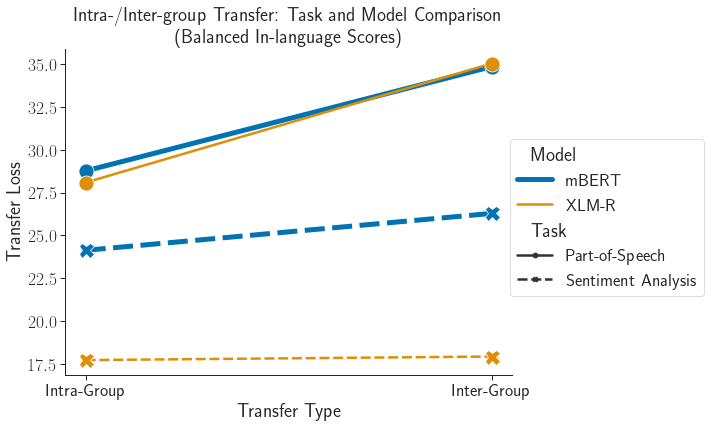

In [8]:
plots.prepare_sns()
sns.set_context("paper", font_scale=2)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

#colors = {sns.desaturate(c, 0.25) for c in plots.get_dual_bar_colors()}

g1 = sns.lineplot(x="Test-Group", 
                  y="Transfer-Loss", 
                  hue="Model", 
                  data=df,
                  palette=sns.color_palette("colorblind", n_colors=2), 
                  linewidth=2.5, 
                  ax=ax, 
                  legend=True, 
                  dashes=True, 
                  style="Task", 
                  markers=True, 
                  markersize=15)

leg = ax.get_legend()
leg.set_bbox_to_anchor((0.95, 0.25, 0.5, 0.5))

for i in range(6):
    if i == 1:
        leg.legendHandles[i].set_linewidth(5)
    else:
        leg.legendHandles[i].set_linewidth(2.5)

plt.setp(ax.lines[:2], linewidth=5)
    
ax.set_title("Intra-/Inter-group Transfer: Task and Model Comparison\n(Balanced In-language Scores)", y=1)
ax.set_xlabel("Transfer Type")
ax.set_ylabel("Transfer Loss")

sns.despine()
plt.show()
fig.savefig("../../../results/acl-score-limit/plots/task_comparison.pdf", dpi=400, bbox_inches="tight")
plt.close()